In [5]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Conv2DTranspose
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from random import randint
import sys, gc, time, shutil, os

import numpy as np

In [6]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Conv2DTranspose
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from random import randint
import sys, gc

import numpy as np

In [7]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        self.SAMPLE_SIZE = 0.01
        optimizer = Adam(0.0002, 0.5)
        
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(1,1,self.latent_dim))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        generator = Sequential()

        generator.add(Dense(units=7 * 7 * 512, kernel_initializer='glorot_uniform', input_shape=(1, 1, self.latent_dim)))
        generator.add(Reshape(target_shape=(7, 7, 512)))
        generator.add(BatchNormalization(momentum=0.5))
        generator.add(Activation('relu'))

        generator.add(Conv2DTranspose(filters=256, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same',
                                  data_format='channels_last',
                                  kernel_initializer='glorot_uniform'))
        generator.add(BatchNormalization(momentum=0.5))
        generator.add(Activation('relu'))

#         generator.add(Conv2DTranspose(filters=128, kernel_size=(5, 5),
#                                   strides=(2, 2), padding='same',
#                                   data_format='channels_last',
#                                   kernel_initializer='glorot_uniform'))
#         generator.add(BatchNormalization(momentum=0.5))
#         generator.add(Activation('relu'))

#         generator.add(Conv2DTranspose(filters=64, kernel_size=(5, 5),
#                                   strides=(2, 2), padding='same',
#                                   data_format='channels_last',
#                                   kernel_initializer='glorot_uniform'))
#         generator.add(BatchNormalization(momentum=0.5))
#         generator.add(Activation('relu'))

        generator.add(Conv2DTranspose(filters=1, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same',
                                  data_format='channels_last',
                                  kernel_initializer='glorot_uniform'))
        generator.add(Activation('tanh'))
      
        print('generator summary')
        generator.summary()
        return generator



    def build_discriminator(self):

        discriminator = Sequential()
        discriminator.add(Conv2D(filters=64, kernel_size=(5, 5),
                                 strides=(2, 2), padding='same',
                                 data_format='channels_last',
                                 kernel_initializer='glorot_uniform',
                                 input_shape=(self.img_shape)))
        discriminator.add(LeakyReLU(0.2))

        discriminator.add(Conv2D(filters=128, kernel_size=(5, 5),
                                 strides=(2, 2), padding='same',
                                 data_format='channels_last',
                                 kernel_initializer='glorot_uniform'))
        discriminator.add(BatchNormalization(momentum=0.5))
        discriminator.add(LeakyReLU(0.2))

        discriminator.add(Conv2D(filters=256, kernel_size=(5, 5),
                                 strides=(2, 2), padding='same',
                                 data_format='channels_last',
                                 kernel_initializer='glorot_uniform'))
        discriminator.add(BatchNormalization(momentum=0.5))
        discriminator.add(LeakyReLU(0.2))

        discriminator.add(Conv2D(filters=512, kernel_size=(5, 5),
                                 strides=(2, 2), padding='same',
                                 data_format='channels_last',
                                 kernel_initializer='glorot_uniform'))
        discriminator.add(BatchNormalization(momentum=0.5))
        discriminator.add(LeakyReLU(0.2))

        discriminator.add(Flatten())
        discriminator.add(Dense(1))
        discriminator.add(Activation('sigmoid'))
        
        
        print('discriminator summary')
        discriminator.summary()
        return discriminator

        

        

    def train(self, epochs, batch_size=128, save_interval= 50):
        g_losses = []
        d_losses = []

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        
        print("Train Shape{}:Sample Images shown below".format(X_train.shape))
        self.display_random_images(X_train)

        #Number of batches = number of images dvided by bath_size 
        number_of_batches = int(X_train.shape[0] / batch_size)
        print('Number of batches', number_of_batches, 'Batch Size', batch_size)
        
        
        for epoch in range(epochs):
            start_time = time.time() 
            starting_idx = 0
            print("Epoch {} of {}".format(epoch+1, epochs))
            for batch_number in range(number_of_batches):                              
                
                real_images = X_train[starting_idx: starting_idx + batch_size]
                starting_idx +=  batch_size
                
#               The actual batch size is given by the number of samples in data as the last batch will have less number
#               of images than batch_size
                current_batch_size = real_images.shape[0]

        
#               Generate noise of shape (current_batcg size, 1, 1 , 100)
                noise = np.random.normal(0, 1, size=(current_batch_size,) + (1, 1, self.latent_dim))
    
#               Generate Fake images
                generated_images = self.generator.predict(noise)
    
#               Add some noise to the labels that will be fed to the discriminator
#               real_y will have random values from 0.8 to 1 and fake_y will have random values from 0 to 0.2
                real_y = (np.ones(current_batch_size) - np.random.random_sample(current_batch_size) * 0.2)
                fake_y = np.random.random_sample(current_batch_size) * 0.2
                
#                Discrimnator is trained in real and fake images
                self.discriminator.trainable = True
                d_loss_real = self.discriminator.train_on_batch(real_images, real_y)
                d_loss_fake = self.discriminator.train_on_batch(generated_images, fake_y)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                
                
#               Train the generator such that the fake samples generated as passed as Real to discriminator. Goal is to
#               let discriminator evaluate the fake images as real while weights are not updated at the same time
                self.discriminator.trainable = False
                noise = np.random.normal(0, 1, size=(current_batch_size * 2,) +  (1, 1, self.latent_dim))
#               Fake labels are passed as real
                fake_y = (np.ones(current_batch_size * 2) - np.random.random_sample(current_batch_size * 2) * 0.2)
                g_loss = self.combined.train_on_batch(noise, fake_y)       
               
                
#           Plot the progress after every epoch
            d_losses.append(d_loss[0])
            g_losses.append(g_loss)
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch+1, d_loss[0], 100*d_loss[1], g_loss))
            print('Time Elapsed {:0.2f}'.format(time.time() - start_time))
            self.save_imgs(epoch, show_fig = True)
            
            
#           Display Imgaes and Grapth every 10 Epochs
            if  (epoch+1) % save_interval == 0:
               self.save_imgs(epoch, show_fig = True)
               self.display_losses(epoch, d_losses, g_losses)
             


    def save_imgs(self, epoch, show_fig = False):
        r, c = 5, 5
#         noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        noise = np.random.normal(0, 1, size=(r*c,) +  (1, 1, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 256        
        gen_imgs = (255*(gen_imgs - np.min(gen_imgs))/np.ptp(gen_imgs)).astype(int)
        
        plt.figure(figsize=(5,5))       

        for i in range(r*c):            
            plt.subplot(r, c, i+1)
            plt.imshow(gen_imgs[i, :,:,0], cmap = 'gray')
            plt.axis('off')
        
        if show_fig:
            plt.show()
        else: 

            filename = "image_%d.png" % epoch
            plt.savefig(os.path.join(filename  ))
        plt.close()
        
    def display_losses(self,epoch, d_loss, g_loss):    
        epochs = list(range(0, epoch + 1))
        plt.figure(figsize = (12, 6))
        plt.ylim(0,3)
        plt.plot(epochs,  d_loss, color = 'red', label = 'Discriminator Loss')
        plt.plot(epochs , g_loss, color = 'blue', label = 'Generator Loss')        
        plt.legend()
        plt.show()

    
    
    def display_random_images(self, X_train):
        plt.figure(figsize=(8,8))
        for i in range(64):
            plt.subplot(8,8,i+1)
            random_idx = randint(0, X_train.shape[0] -1)
            image = X_train[random_idx,:,:,0]
             # Rescale images 0 - 256        
            image = (255*(image - np.min(image))/np.ptp(image)).astype(int)
            plt.imshow(image, cmap = 'gray')
        plt.show()

discriminator summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_7 (Batch (None, 4, 4, 256)        

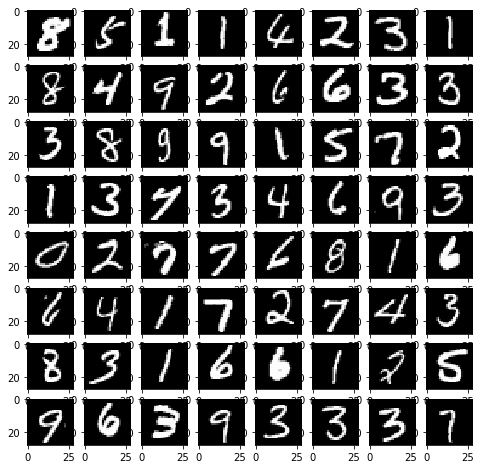

Number of batches 937 Batch Size 64
Epoch 1 of 1000
1 [D loss: 0.337637, acc.: 0.00%] [G loss: 1.936593]
Time Elapsed 66.94


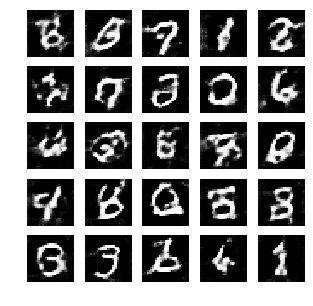

Epoch 2 of 1000
2 [D loss: 0.354541, acc.: 0.00%] [G loss: 2.329127]
Time Elapsed 62.58


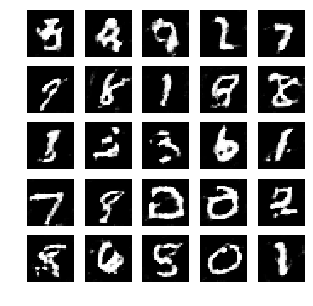

Epoch 3 of 1000
3 [D loss: 0.350810, acc.: 0.00%] [G loss: 2.942584]
Time Elapsed 62.59


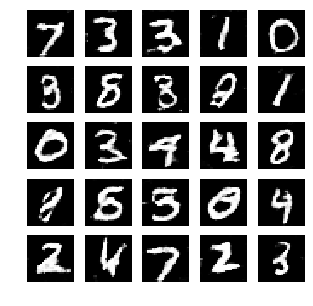

Epoch 4 of 1000
4 [D loss: 0.329154, acc.: 0.00%] [G loss: 1.724819]
Time Elapsed 62.48


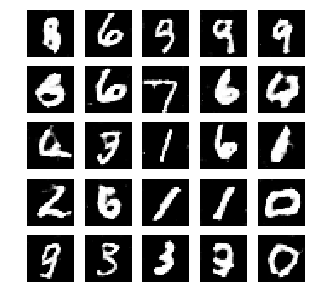

Epoch 5 of 1000
5 [D loss: 0.395862, acc.: 0.00%] [G loss: 3.128509]
Time Elapsed 62.64


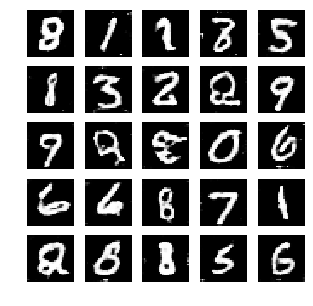

Epoch 6 of 1000
6 [D loss: 0.347081, acc.: 0.00%] [G loss: 2.820768]
Time Elapsed 62.72


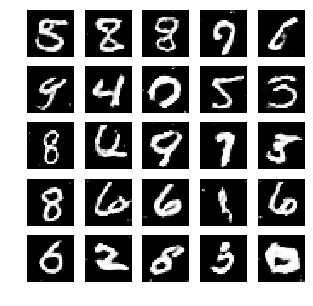

Epoch 7 of 1000
7 [D loss: 0.339087, acc.: 0.00%] [G loss: 2.826635]
Time Elapsed 62.54


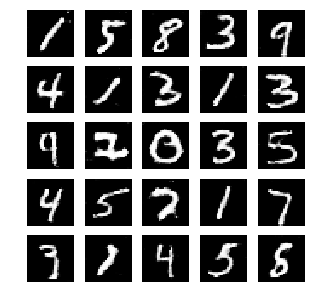

Epoch 8 of 1000
8 [D loss: 0.347923, acc.: 0.00%] [G loss: 2.185936]
Time Elapsed 62.58


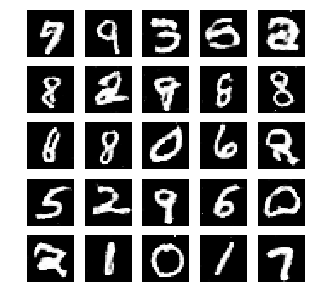

Epoch 9 of 1000
9 [D loss: 0.396557, acc.: 0.00%] [G loss: 2.527714]
Time Elapsed 62.36


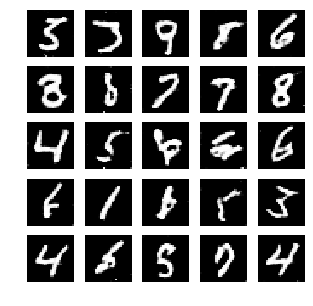

Epoch 10 of 1000
10 [D loss: 0.427614, acc.: 0.00%] [G loss: 2.653563]
Time Elapsed 62.80


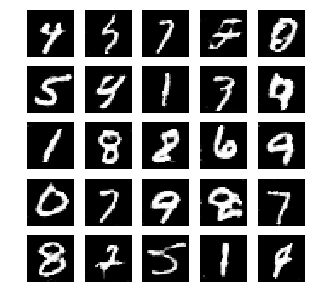

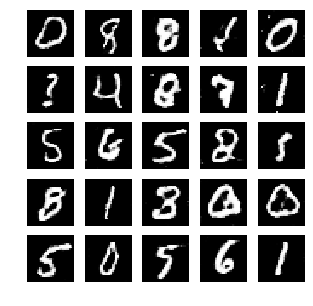

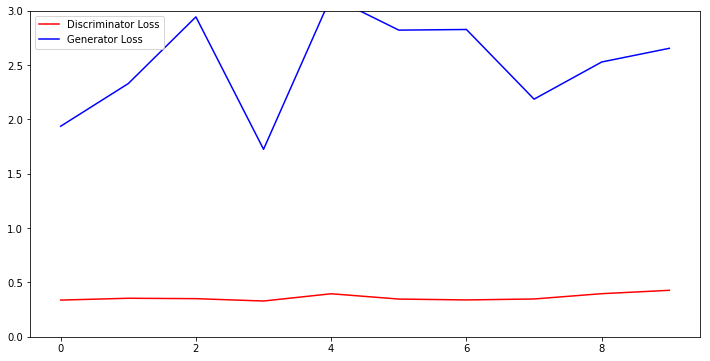

Epoch 11 of 1000
11 [D loss: 0.399778, acc.: 0.00%] [G loss: 2.157248]
Time Elapsed 62.61


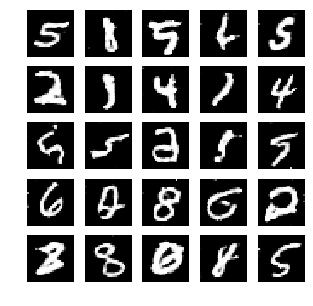

Epoch 12 of 1000
12 [D loss: 0.398362, acc.: 0.00%] [G loss: 2.578964]
Time Elapsed 62.53


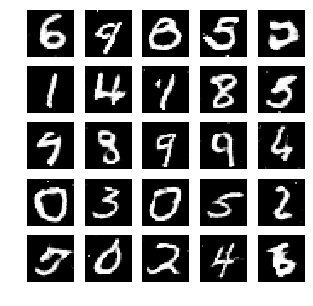

Epoch 13 of 1000
13 [D loss: 0.390617, acc.: 0.00%] [G loss: 3.232055]
Time Elapsed 62.59


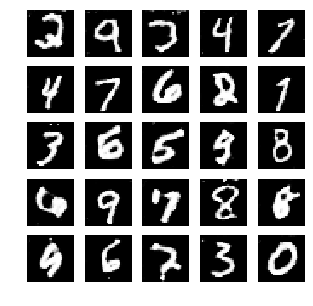

Epoch 14 of 1000
14 [D loss: 0.405119, acc.: 0.00%] [G loss: 2.712165]
Time Elapsed 62.47


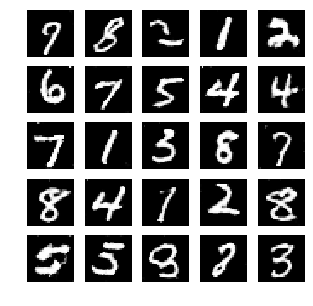

Epoch 15 of 1000
15 [D loss: 0.412753, acc.: 0.00%] [G loss: 2.664876]
Time Elapsed 62.85


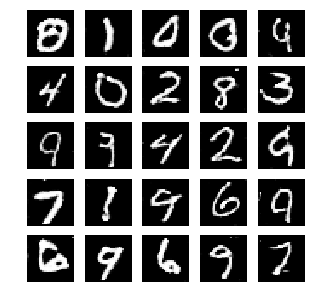

Epoch 16 of 1000
16 [D loss: 0.392133, acc.: 0.00%] [G loss: 2.503989]
Time Elapsed 62.55


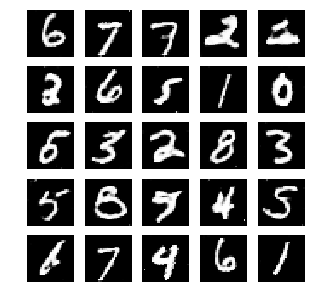

Epoch 17 of 1000
17 [D loss: 0.404959, acc.: 0.00%] [G loss: 3.065785]
Time Elapsed 62.55


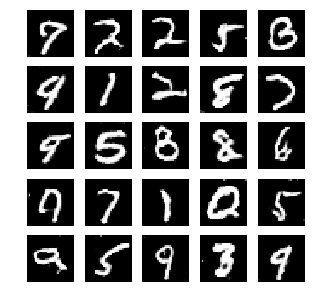

Epoch 18 of 1000
18 [D loss: 0.378889, acc.: 0.00%] [G loss: 2.592647]
Time Elapsed 62.55


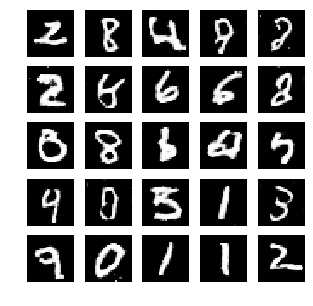

Epoch 19 of 1000
19 [D loss: 0.437020, acc.: 0.00%] [G loss: 2.481895]
Time Elapsed 62.51


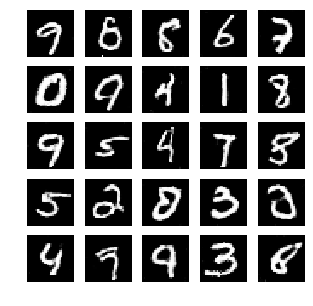

Epoch 20 of 1000
20 [D loss: 0.436966, acc.: 0.00%] [G loss: 3.250953]
Time Elapsed 62.82


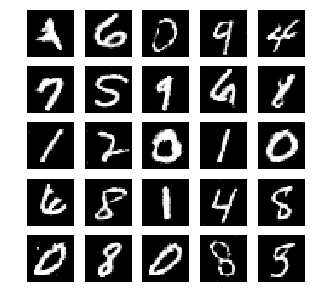

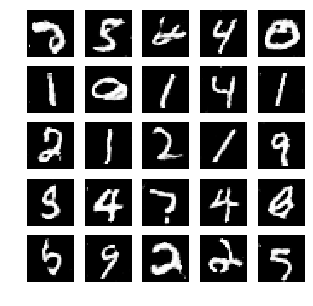

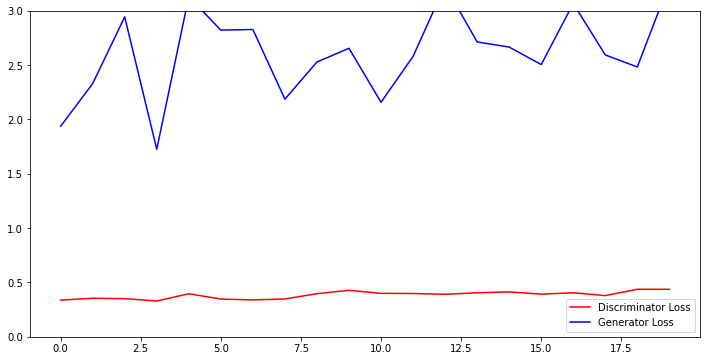

Epoch 21 of 1000
21 [D loss: 0.393997, acc.: 0.00%] [G loss: 2.829897]
Time Elapsed 62.50


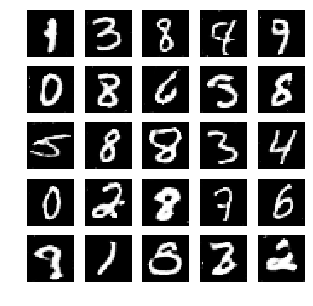

Epoch 22 of 1000
22 [D loss: 0.352257, acc.: 0.00%] [G loss: 3.809508]
Time Elapsed 62.54


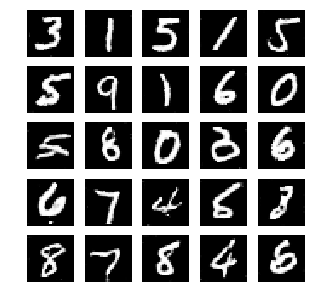

Epoch 23 of 1000
23 [D loss: 0.400035, acc.: 0.00%] [G loss: 2.884132]
Time Elapsed 62.51


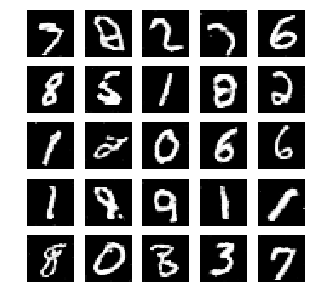

Epoch 24 of 1000
24 [D loss: 0.400008, acc.: 0.00%] [G loss: 2.314763]
Time Elapsed 62.48


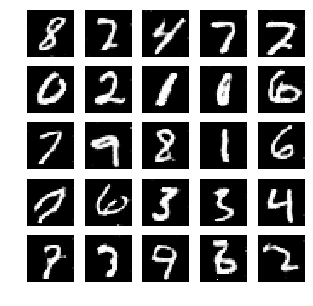

Epoch 25 of 1000
25 [D loss: 0.343227, acc.: 0.00%] [G loss: 2.266464]
Time Elapsed 62.79


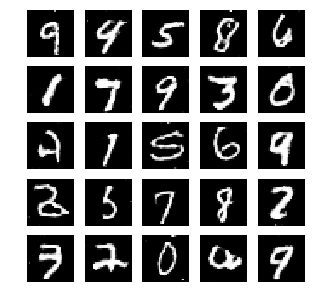

Epoch 26 of 1000
26 [D loss: 0.352705, acc.: 0.00%] [G loss: 2.030245]
Time Elapsed 62.54


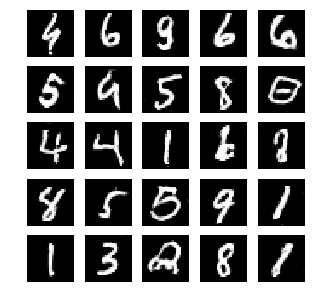

Epoch 27 of 1000
27 [D loss: 0.406611, acc.: 0.00%] [G loss: 3.657444]
Time Elapsed 62.56


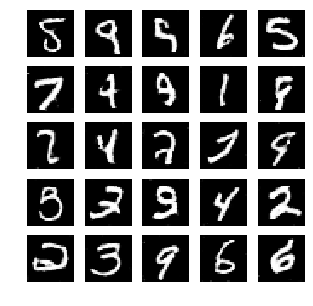

Epoch 28 of 1000
28 [D loss: 0.419521, acc.: 0.00%] [G loss: 2.806285]
Time Elapsed 62.46


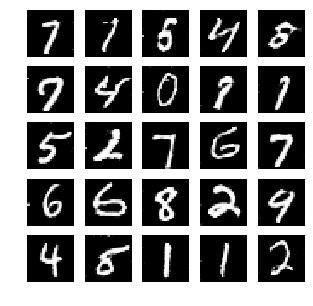

Epoch 29 of 1000
29 [D loss: 0.414688, acc.: 0.00%] [G loss: 2.087364]
Time Elapsed 62.51


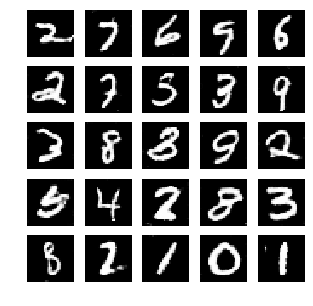

Epoch 30 of 1000
30 [D loss: 0.350781, acc.: 0.00%] [G loss: 2.707608]
Time Elapsed 62.81


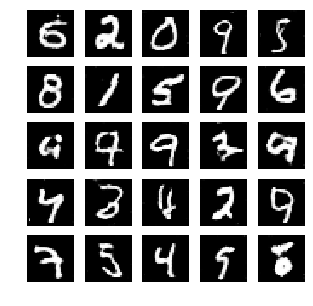

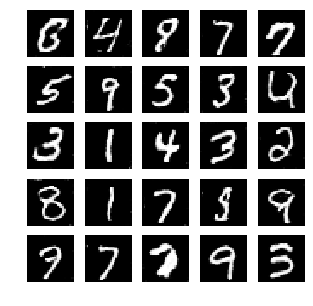

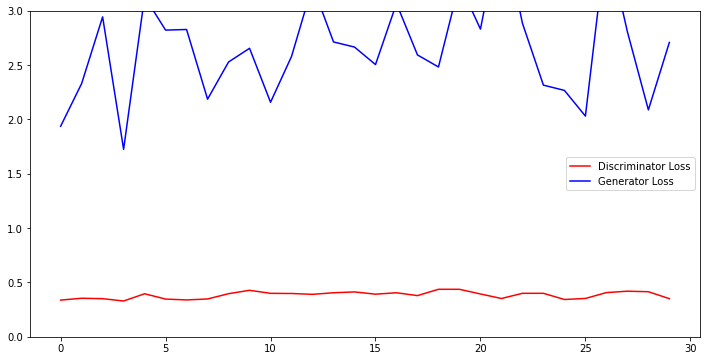

Epoch 31 of 1000
31 [D loss: 0.385860, acc.: 0.00%] [G loss: 2.381866]
Time Elapsed 62.57


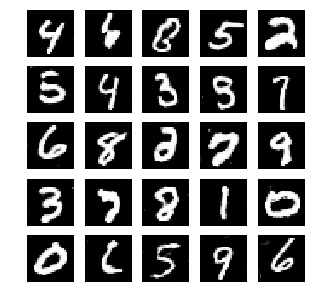

Epoch 32 of 1000
32 [D loss: 0.426185, acc.: 0.00%] [G loss: 2.640594]
Time Elapsed 62.51


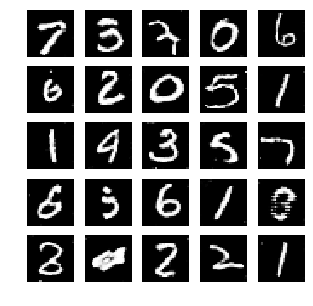

Epoch 33 of 1000
33 [D loss: 0.397816, acc.: 0.00%] [G loss: 2.499287]
Time Elapsed 62.38


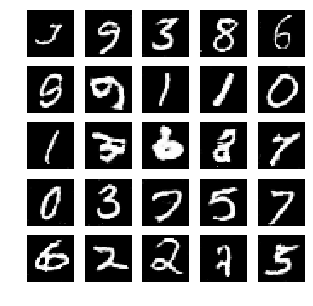

Epoch 34 of 1000
34 [D loss: 0.386674, acc.: 0.00%] [G loss: 1.573055]
Time Elapsed 62.45


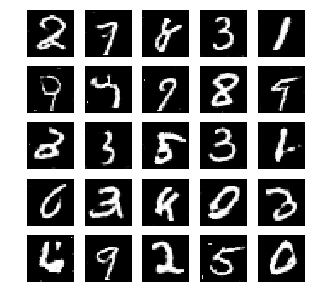

Epoch 35 of 1000
35 [D loss: 0.357442, acc.: 0.00%] [G loss: 2.140653]
Time Elapsed 62.60


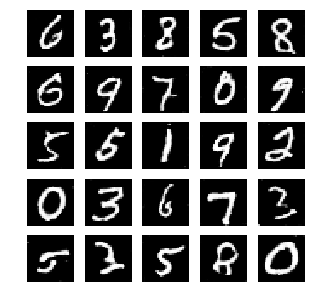

Epoch 36 of 1000
36 [D loss: 0.368125, acc.: 0.00%] [G loss: 2.370929]
Time Elapsed 62.50


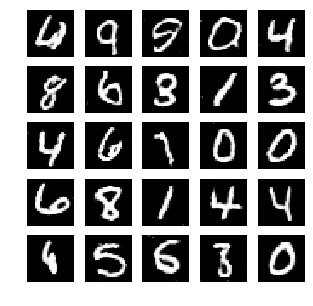

Epoch 37 of 1000
37 [D loss: 0.373947, acc.: 0.00%] [G loss: 2.931561]
Time Elapsed 62.50


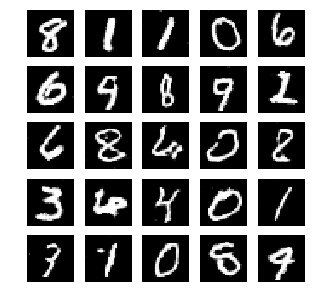

Epoch 38 of 1000
38 [D loss: 0.357705, acc.: 0.00%] [G loss: 2.100159]
Time Elapsed 62.40


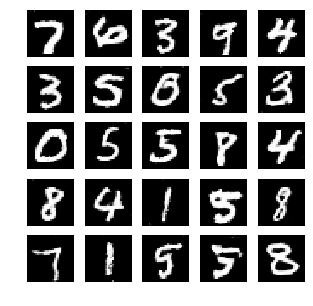

Epoch 39 of 1000
39 [D loss: 0.367930, acc.: 0.00%] [G loss: 2.115300]
Time Elapsed 62.45


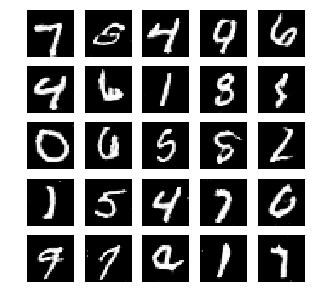

Epoch 40 of 1000
40 [D loss: 0.341669, acc.: 0.00%] [G loss: 2.417196]
Time Elapsed 62.75


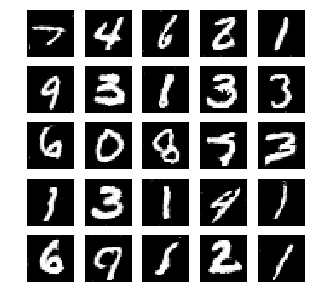

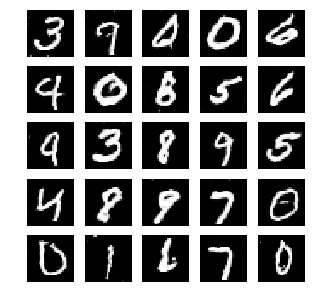

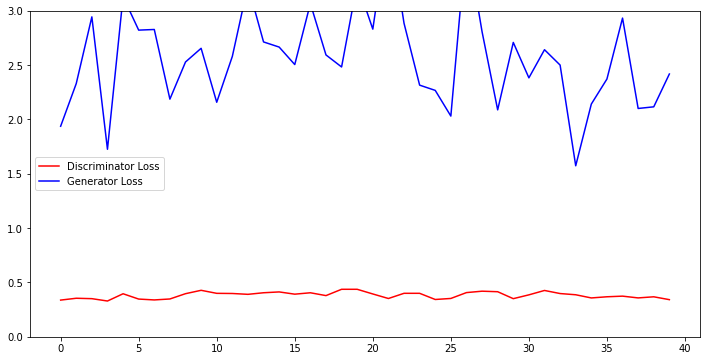

Epoch 41 of 1000
41 [D loss: 0.347185, acc.: 0.00%] [G loss: 2.111022]
Time Elapsed 62.44


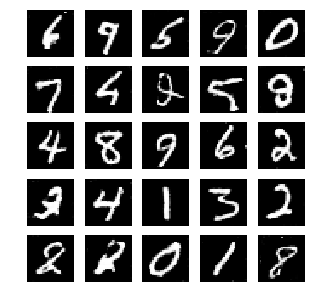

Epoch 42 of 1000
42 [D loss: 0.345902, acc.: 0.00%] [G loss: 1.598818]
Time Elapsed 62.48


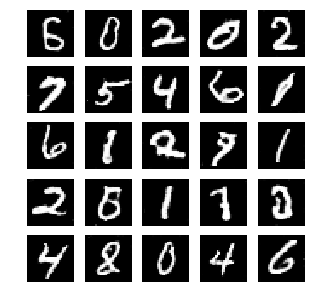

Epoch 43 of 1000
43 [D loss: 0.410963, acc.: 0.00%] [G loss: 1.942293]
Time Elapsed 62.41


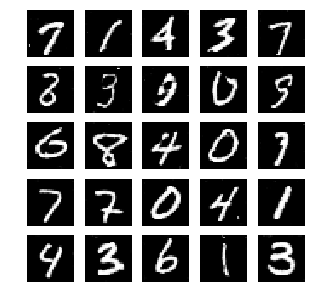

Epoch 44 of 1000
44 [D loss: 0.365185, acc.: 0.00%] [G loss: 1.801160]
Time Elapsed 62.43


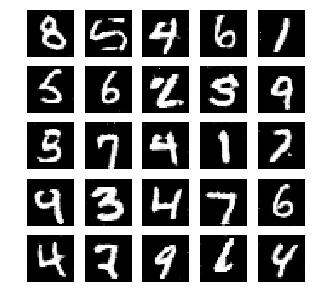

Epoch 45 of 1000
45 [D loss: 0.362518, acc.: 0.00%] [G loss: 2.330405]
Time Elapsed 62.68


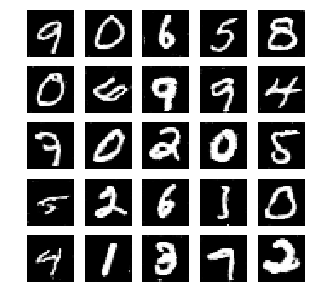

Epoch 46 of 1000
46 [D loss: 0.324745, acc.: 0.00%] [G loss: 2.069889]
Time Elapsed 62.40


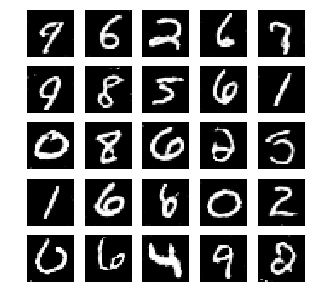

Epoch 47 of 1000
47 [D loss: 0.345331, acc.: 0.00%] [G loss: 1.875346]
Time Elapsed 62.34


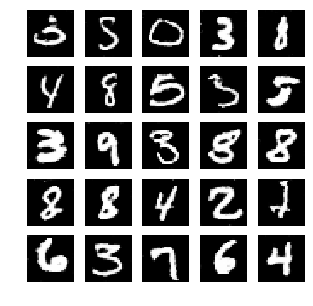

Epoch 48 of 1000
48 [D loss: 0.327918, acc.: 0.00%] [G loss: 2.237315]
Time Elapsed 62.36


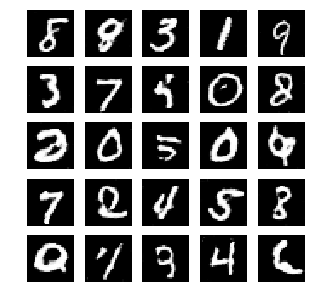

Epoch 49 of 1000
49 [D loss: 0.379595, acc.: 0.00%] [G loss: 2.780372]
Time Elapsed 62.58


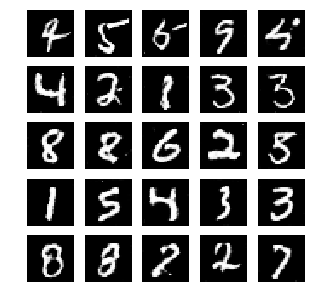

Epoch 50 of 1000
50 [D loss: 0.388470, acc.: 0.00%] [G loss: 2.378156]
Time Elapsed 62.64


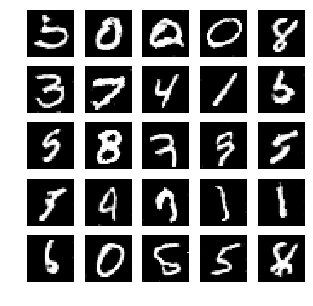

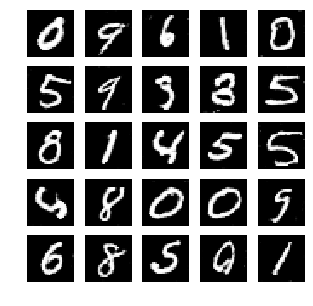

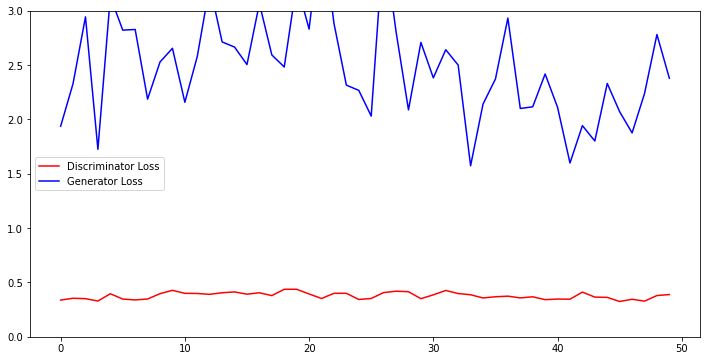

Epoch 51 of 1000
51 [D loss: 0.381887, acc.: 0.00%] [G loss: 1.623896]
Time Elapsed 62.48


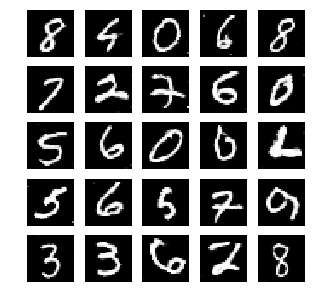

Epoch 52 of 1000
52 [D loss: 0.361463, acc.: 0.00%] [G loss: 2.163332]
Time Elapsed 62.38


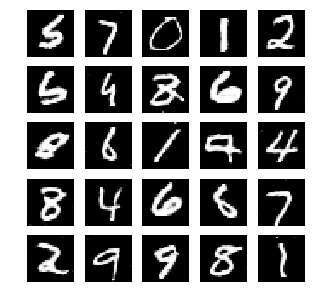

Epoch 53 of 1000
53 [D loss: 0.449754, acc.: 0.00%] [G loss: 2.437465]
Time Elapsed 62.39


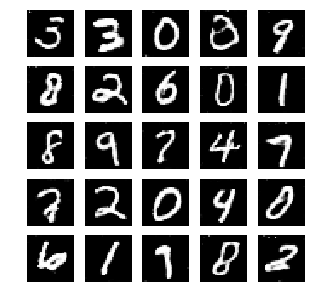

Epoch 54 of 1000


In [ ]:
if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=1000, batch_size= 64, save_interval= 10)